In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.auto import tqdm



from typing import Optional, List, Dict, Union
from jaxtyping import Float
from torch import Tensor

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import Tensor
from torch import optim
from torch.utils.data import random_split, DataLoader, TensorDataset

from pathlib import Path
from einops import rearrange

import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    AutoConfig,
)
from peft import (
    get_peft_config,
    get_peft_model,
    LoraConfig,
    TaskType,
    LoftQConfig,
    IA3Config,
)
from pathlib import Path
import datasets
from datasets import Dataset

from loguru import logger

logger.add(os.sys.stderr, format="{time} {level} {message}", level="INFO")

# load my code
%load_ext autoreload
%autoreload 2

import lightning.pytorch as pl

from src.config import ExtractConfig
from src.llms.load import load_model
from src.helpers.torch_helpers import clear_mem
from src.llms.phi.model_phi import PhiForCausalLMWHS
from src.eval.ds import filter_ds_to_known
from src.datasets.act_dm import ActivationDataModule

# plt.style.use("ggplot")
# plt.style.use("seaborn-v0_8")
import seaborn as sns
sns.set_theme('paper')


# Original from callummcdougall/sae-exercises-mats

https://github.com/callummcdougall/sae-exercises-mats/blob/116ecf3f8f7ffcd66cf628518009f81989e57bac/solutions.py

In [3]:
from torchinfo import summary

batch_size = 4
n_layers = 3
n_channels = 5
hidden = 2
x = torch.rand([batch_size, n_layers, n_channels])
print(x.shape)
x = torch.rand([1, 1, n_channels])
x = x.repeat([batch_size, n_layers, 1],)
x.shape

torch.Size([4, 3, 5])


torch.Size([4, 3, 5])

In [4]:

from src.vae.conv_inception import PLAE, LinBnDrop, PLBase, recursive_requires_grad, accuracy, auroc

from src.vae.sae import AutoEncoder, AutoEncoderConfig


ae_cfg = AutoEncoderConfig(
    n_instances=n_layers,
    n_input_ae=n_channels,
    n_hidden_ae=hidden,
    tied_weights=False,
)
ae = AutoEncoder(
    ae_cfg,
)


# with torch.no_grad():
#     y = ae(x)

summary(ae, input_data=x, depth=4)  # input_size=(batch_size, 1, 28, 28))


Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [4]                       81
Total params: 81
Trainable params: 81
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

# A simpler version, with multi layers

In [78]:

from src.vae.conv_inception import PLAE, LinBnDrop, PLBase, recursive_requires_grad, accuracy, auroc

from src.vae.sae2 import AutoEncoder, AutoEncoderConfig


ae_cfg = AutoEncoderConfig(
    n_instances=n_layers,
    n_input_ae=n_channels,
    n_hidden_ae=hidden,
    tied_weights=False,
)
ae = AutoEncoder(
    ae_cfg,
)


# with torch.no_grad():
#     y = ae(x)

summary(ae, input_data=x, depth=4)  # input_size=(batch_size, 1, 28, 28))


Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [4]                       81
Total params: 81
Trainable params: 81
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [85]:
from src.vae.sae2 import Normed2dLinear

l = Normed2dLinear(n_instances=n_layers, n_input_ae=n_channels, n_output=hidden)
x.shape, l(x).shape

(torch.Size([4, 3, 5]), torch.Size([4, 3, 2]))

In [106]:
# Did it apply the same weights to each layer?
l(x).mean(2).mean(0)

tensor([0.0548, 0.6078, 0.4261], grad_fn=<MeanBackward1>)

In [86]:
l.bias.shape, x.shape, n_channels

(torch.Size([3, 2]), torch.Size([4, 3, 5]), 5)

In [87]:
from sparse_autoencoder.autoencoder.components.unit_norm_decoder import UnitNormDecoder

l2 = UnitNormDecoder(learnt_features=n_channels, decoded_features=hidden, n_components=n_layers)
x.shape, l2(x).shape
# TODO check norm

(torch.Size([4, 3, 5]), torch.Size([4, 3, 2]))

In [105]:
# Did it apply the same weights to each layer?
l2(x).mean(2).mean(0)

tensor([ 0.0327,  0.8120, -0.0023], grad_fn=<MeanBackward1>)

In [88]:
l3 = nn.Linear(in_features=n_channels, out_features=hidden, bias=False)
x.shape, l3(x).shape


(torch.Size([4, 3, 5]), torch.Size([4, 3, 2]))

In [104]:
# Did it apply the same weights to each layer?
l3(x).mean(2).mean(0)

tensor([-0.3358, -0.3358, -0.3358], grad_fn=<MeanBackward1>)

In [90]:
l2.weight.shape

x.shape

torch.Size([4, 3, 5])

In [109]:
class NormedLinear(nn.Linear):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.weight_norm()

    @torch.no_grad
    def weight_norm(self) -> None:
        F.normalize(self.weight, dim=1, out=self.weight)

class NormedLinears(nn.Module):
    def __init__(self, n_instances: int, n_input_ae: int, n_output: int):
        super().__init__()
        self.linears = nn.ModuleList(NormedLinear(n_input_ae, n_output) for _ in range(n_instances))

    def weight_norm(self) -> None:
        for m in self.linears:
            m.weight_norm()

    def forward(self, x: Tensor) -> Tensor:
        return torch.stack([m(x[:, i]) for i, m in enumerate(self.linears)], dim=1)

    

l5 = Normed2dLinear2(n_instances=n_layers, n_input_ae=n_channels, n_output=hidden)
x.shape, l5(x).shape
# TODO check norm

(torch.Size([4, 3, 5]), torch.Size([4, 3, 2]))

In [91]:
class NormedLinear(nn.Linear):
    def __init__(self, n_instances, n_input_ae, n_output, bias=True):
        super().__init__(in_features=n_instances*n_input_ae, out_features=n_instances*n_output, bias=bias)
        self.n_instances = n_instances
        self.n_input_ae = n_input_ae
        self.n_output = n_output
        self.weight_norm()

    @torch.no_grad
    def weight_norm(self) -> None:
        F.normalize(self.weight, dim=-2, out=self.weight)

    def forward(self, x):
        x = rearrange(x, 'b n c -> b (n c)')
        x = F.linear(x, self.weight)
        x = rearrange(x, 'b (n o) -> b n o', n=self.n_instances)
        return x
    

l4 = NormedLinear(n_instances=n_layers, n_input_ae=n_channels, n_output=hidden)
x.shape, l4(x).shape
# TODO check norm

(torch.Size([4, 3, 5]), torch.Size([4, 3, 2]))

In [103]:
# Did it apply the same weights to each layer?
l4(x).mean(2).mean(0)

tensor([-0.3438,  1.4669, -0.2119], grad_fn=<MeanBackward1>)

In [93]:
print(l.weight.shape)
nd2= torch.sqrt((l.weight ** 2).sum(1)).mean(0)
nd1= torch.sqrt((l.weight ** 2).sum(2)).mean(0)
nd1, nd2

torch.Size([3, 5, 2])


(tensor([0.5391, 0.7021, 0.6275, 0.6966, 0.5196], grad_fn=<MeanBackward1>),
 tensor([1., 1.], grad_fn=<MeanBackward1>))

In [94]:
print(l2.weight.shape)
nd2= torch.sqrt((l2.weight ** 2).sum(1)).mean(0)
nd1= torch.sqrt((l2.weight ** 2).sum(2)).mean(0)
nd1, nd2

torch.Size([3, 2, 5])


(tensor([1.6746, 1.4694], grad_fn=<MeanBackward1>),
 tensor([1., 1., 1., 1., 1.], grad_fn=<MeanBackward1>))

In [65]:
print(l3.weight.shape)
nd2= torch.sqrt((l3.weight ** 2).sum(0)).mean(0)
nd1= torch.sqrt((l3.weight ** 2).sum(1)).mean(0)
nd1, nd2

torch.Size([2, 5])


(tensor(0.6134, grad_fn=<MeanBackward1>),
 tensor(0.3779, grad_fn=<MeanBackward1>))

In [66]:
print(l4.weight.shape)
nd2= torch.sqrt((l4.weight ** 2).sum(0)).mean(0)
nd1= torch.sqrt((l4.weight ** 2).sum(1)).mean(0)
nd1, nd2

torch.Size([6, 15])


(tensor(1.5629, grad_fn=<MeanBackward1>), tensor(1., grad_fn=<MeanBackward1>))

In [114]:
w = l5.linears[0].weight
print(l5.linears[0].weight.shape)
nd2= torch.sqrt((w ** 2).sum(0)).mean(0)
nd1= torch.sqrt((w ** 2).sum(1)).mean(0)
nd1, nd2

torch.Size([2, 5])


(tensor(1.4729, grad_fn=<MeanBackward1>), tensor(1., grad_fn=<MeanBackward1>))

OK so, the advantage of the custom linear is

- The normal linear would apply the same weights to each layer. as would a conv
- Their one has differen't weights for each layer, but it's not all to all, which saves on computations

In [119]:
x.shape, batch_size, n_layers, n_channels

(torch.Size([4, 3, 5]), 4, 3, 5)

In [122]:
l = nn.BatchNorm1d(n_layers)
l(x).shape, l.running_mean.shape

(torch.Size([4, 3, 5]), torch.Size([3]))

In [128]:
l = nn.LayerNorm(n_channels)
l(x).shape

AttributeError: 'LayerNorm' object has no attribute 'running_mean'

In [134]:
l = nn.InstanceNorm1d(n_layers, affine=False, track_running_stats=True)
l(x).shape, l.running_mean.shape

(torch.Size([4, 3, 5]), torch.Size([3]))

In [139]:
from src.vae.sae2 import Affines
l = Affines(n_layers, n_channels)
l(x).shape

torch.Size([4, 3, 5])

In [142]:
l.affines[0].running_mean.shape

torch.Size([5])

In [144]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

True

: 

In [9]:
import numpy as np
# We want a pyramidal, log spaced, hidden states.
n_input_ae = 20345
depth = 5
n_hidden_ae = 128
encoder_sizes = (
    np.logspace(
        np.log10(n_input_ae), np.log10(n_hidden_ae), depth + 1
    ).astype(int)
    
)
# encoder_sizes = encoder_sizes // 8 # make them even smaller
# encoder_sizes = encoder_sizes.clip(n_hidden_ae, n_input_ae)

encoder_sizes = [n_input_ae] + list(encoder_sizes[1:-1]) + [n_hidden_ae]
encoder_sizes

[20345, 7382, 2678, 972, 352, 128]

0.05 [23040   128   128   128   128]
0.09090909090909091 [23040  2048  2048   128   128]
0.1 [23040  1024  1024   128   128]
0.2 [23040  7776  3125   243   128]
0.5 [23040 13456  6561  2116   128]
1 [23040 17312 11584  5856   128]
2 [23040 19953 16291 11520   128]
3 [23040 20933 18286 14514   128]
4 [23040 21441 19374 16291   128]
5 [23040   128   128   128   128]


/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/numpy/core/function_base.py:182: RuntimeWarning: invalid value encountered in cast
  return y.astype(dtype, copy=False)
/tmp/ipykernel_2408967/2821752335.py:3: RuntimeWarning: invalid value encountered in power
  s =  np.power(np.linspace(start**power, end**power, num_elements, dtype=int), 1/power).astype(int)
/tmp/ipykernel_2408967/2821752335.py:3: RuntimeWarning: invalid value encountered in cast
  s =  np.power(np.linspace(start**power, end**power, num_elements, dtype=int), 1/power).astype(int)


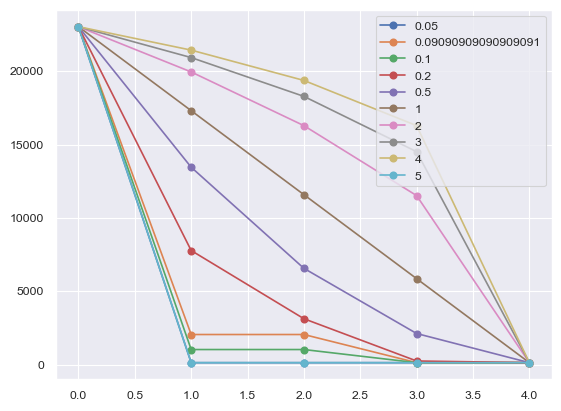

: 

In [93]:
# Custom power spacing
def power_sequence(start: int, end: int, num_elements: int, power: int = 2):
    s =  np.power(np.linspace(start**power, end**power, num_elements, dtype=int), 1/power).astype(int)
    s = np.array([start] + list(s[1:-1]) + [end])
    s = s.clip(end, start)

    assert (np.array(s)>1).all(), 'should be positive'
    assert (np.diff(s)<=0).all(), 'should not be increasing'
    return s

def power_sequence_int(start: int, end: int, num_elements: int, power: int = 2):
    s = power_sequence(start, end, num_elements, power)
    # print(s)
    # ensure no dups, and that we have the right number of elements, and start and end are there
    assert s[0] == start
    assert s[-1] == end
    assert len(s) == num_elements
    # assert len(set(s)) == num_elements
    assert (np.diff(s)<=0).all(), 'should not be increasing'
    assert (np.array(s)>1).all(), 'should be positive'
    return s


n_input_ae = 23040
depth = 4
n_hidden_ae = 128


for p in [1./20, 1./11, 1/10, 1/5, 1/2, 1, 2, 3, 4, 5]:
    s = power_sequence(n_input_ae, n_hidden_ae, depth + 1, power=p)
    print(p, s)
    plt.plot(s, label=p, marker='o')
plt.legend()

linear [23040 17312 11584  5856   128]
log [23040  6290  1717   468   128]
log2 [23040  6290  1717   468   128]


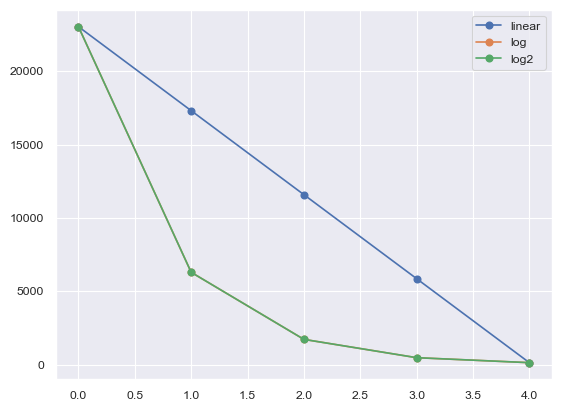

In [92]:
import numpy as np



# Linear sequence
def linear_sequence(start: int, end: int, num_elements: int, mode="linear"):
    if mode=="linear":
        s = np.linspace(start, end, num_elements, dtype=float)
    elif mode=="log":
        s = np.logspace(np.log10(start), np.log10(end), num_elements, dtype=float, base=10)
    elif mode=="log2":
        s = np.logspace(np.log2(start), np.log2(end), num_elements, dtype=float, base=2)
    else:
        raise ValueError(f"Unknown mode {mode}")
    # print(mode, s)
    s = np.array([start] + list(s[1:-1]) + [end]).astype(int)
    s = s.clip(end, start)
    assert (np.diff(s)<=0).all(), 'should not be increasing'
    return s


for mode in ["linear", "log", "log2",]:
    s = linear_sequence(n_input_ae, n_hidden_ae, depth + 3, mode=mode)
    print(mode, s)
    plt.plot(s, label=mode, marker='o')
plt.legend()

# Scheduler

In [21]:
import torch.optim as optim
import torch

total_steps = 100
lr = 1e-3
lr_min = 1e-6
verbose = False
s = optim.lr_scheduler.CyclicLR(optim.Adam([torch.zeros(1)]), base_lr=lr_min, max_lr=lr, step_size_up=total_steps//2, step_size_down=total_steps//2, mode='triangular2', cycle_momentum=False, verbose=verbose)

s1 = optim.lr_scheduler.CosineAnnealingLR(optim.Adam([torch.zeros(1)]), T_max=total_steps, eta_min=lr_min, verbose=verbose)

s2 = optim.lr_scheduler.CosineAnnealingWarmRestarts(optim.Adam([torch.zeros(1)]), T_0=total_steps//2, T_mult=1, eta_min=lr_min, verbose=verbose)

/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


<Axes: >

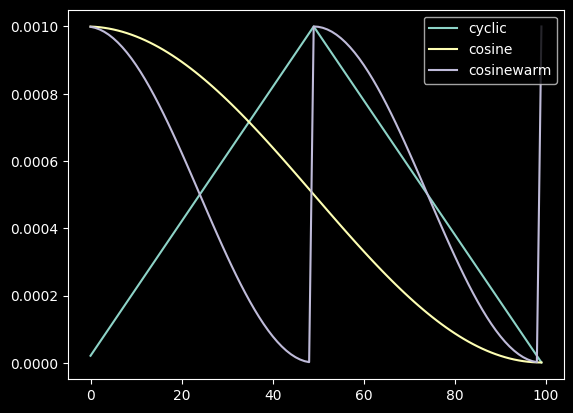

In [22]:
import pandas as pd

data = []

schedulers = dict(cyclic=s, cosine=s1, cosinewarm=s2)
for i in range(total_steps):
    row = {}
    for n, scheduler in schedulers.items():
        scheduler.step()
        row[n]=scheduler.get_last_lr()[0]
    data.append(row)
df_lr = pd.DataFrame(data)
df_lr.plot()